In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

X, y = fetch_openml(
    "mnist_784",
    version=1,
    return_X_y=True,
    as_frame=False   # ensures numpy arrays instead of pandas
)

# Convert pixel values to a float type and scale them (optional, but recommended)
X = X.astype('float32') / 255.0
y = y.astype(int) # converting to int from str

# Split data into training and testing sets if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


c:\Users\Haruku\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
print(X_train.shape, y_train.shape)

(52500, 784) (52500,)


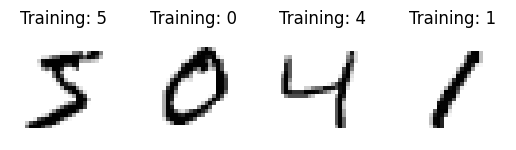

In [3]:
images_and_labels = list(zip(X, y))
for index, (data, label) in enumerate(images_and_labels[:4]):
    imgdim=int(np.sqrt(X[index].shape[0]))
    img=np.reshape(X[index],(imgdim,imgdim))
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.title(f'Training: {label}')

In [4]:
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --------------------------------
# 2. Define Models
# --------------------------------

models = {
    # Tuned MLP (light tuning, no CV)
    "MLP": MLPClassifier(
        hidden_layer_sizes=(256, 256),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=0.001,
        max_iter=3000,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
}


In [5]:
from sklearn.metrics import accuracy_score

# --------------------------------
# 3. Train & Evaluate (may take 3-6 min for XGB)
# --------------------------------

results = []

for name, model in models.items():
    
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc
    })

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

print("\nModel Comparison:\n")
print(results_df)

Training MLP...

Model Comparison:

  Model  Accuracy
0   MLP    0.9776


In [7]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.5.1+cu121
True
NVIDIA GeForce RTX 4060 Ti


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define a transform to convert the data to tensors and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        # x.size(0) return (batch_size, channels, height, width) -- for MNIST x.shape = (64, 1, 28, 28)
        # x.view(x.size(0), -1)  # x.view reshapes/flattens batch properly. -1 to determine the dimension automatically.
        # # but, sklearn mnist is already flattened! so we don't need x.view(...). For torchvision mnist data, we do. 
        x = self.network(x)
        return x
model = FNN()
print(model)



FNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) # long is required for CrossEntropy

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

model = FNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# this makes implementation easier and training more efficient
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # switch to gpu if available
model.to(device)
print(device)

cuda


In [19]:
for epoch in range(100):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 10, Loss: 0.0845
Epoch 20, Loss: 0.0872
Epoch 30, Loss: 0.0839
Epoch 40, Loss: 0.0804
Epoch 50, Loss: 0.0743
Epoch 60, Loss: 0.0751
Epoch 70, Loss: 0.0728
Epoch 80, Loss: 0.0685
Epoch 90, Loss: 0.0690
Epoch 100, Loss: 0.0661


In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# almost indifferent from sklearn MLP, expected.
# sklearn is more optimized and we set "early stopping"
# you may try adding this feature to our training!
# You should know how to use PyTorch for machine/deep learning; 
# next article will introduce you more advanced architecture to handle image processing.

Test Accuracy: 97.23%
